#### Construir um Bag of Visual Words compreende três passos:
- 1. Extração de features: Extração das features das imagens usando ORB;
- 2. Construção de dicionário: É utilizado o algoritmo de agrupamento K-means. Os centroides obtidos são as palavras chaves;
- 3. Quantização de vetor: É criado um histograma para representar a frequência de cada palavra visual.

Foi realizado um treinamento com todos os dados. No entanto, o resultado não foi satisfatório; a rede não conseguiu convergir. Tentei relizar novos ajustes (tunning de modelo, aumento da cluster, uso de outro extrator de features - SIFT), mas a demora no processamento é considerável, impactando no tempo. Quando realizado o treinamento com apenas duas classes, há um bom resultado no modelo. Desse modo, realizei o treinamento com duas classes: gato e cachorro. 

### Import de bibliotecas

In [8]:
import numpy as np
import cv2
import os
from scipy import ndimage
from scipy.spatial import distance
from sklearn.cluster import KMeans
from scipy.cluster.vq import kmeans,vq # Esse módulo é utilizado para quantização vetorial para usar com o K-Means
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skimage import  data, color, feature
import pickle
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd #
import random

## Carregamento de dataset e extração de features

In [2]:
'''
Função para salvar estrutura de dados
em extensão .pckl para posterior uso
'''
def save_data(data, save_path):
    with open(save_path, 'wb') as f:
        pickle.dump(data, f)

'''
Função para carregar estrutura de dados
salva em extensão .pckl
'''
def load_data(data_path):
    with open(data_path, 'rb') as f:
        return pickle.load(f)

'''
Função para extração de features
usando ORB
'''
def get_orb_features(img):
    orb = cv2.ORB_create()
    kp = orb.detect(img,None)
    kp, des = orb.compute(img, kp)
    return des


#def get_sift_features(img):
#    orb = cv2.ORB_create()
#    kp = orb.detect(img,None)
#    kp, des = orb.compute(img, kp)
#    return des
    
'''
Função para carregamento de dataset
Recebe o diretório das imagens e,
opcionalmente, faz o resize delas.
Optou-se pelo resize por conta dos
recursos computacionais.
'''
def load_dataset(folder_path, save = True, 
                 save_path = './dataset/dataset.pkl',
                resize = True, resolution = (150,150)):
    dataset = []
    for filename in os.listdir(folder_path):
        path = folder_path + '/' + filename
        print('== >', filename)
        for img_path in os.listdir(path):
            # Carrega imagem em escala de cinza para posterior processamento
            img = cv2.imread(path + '/' + img_path, 0)
            if img is not None:
                if resize:
                    img = cv2.resize(img, resolution)
                # Obtém os descritores a partir do orb
                orb_descriptor = get_orb_features(img)
                #hog_descriptor = get_hog(img)
                
                if orb_descriptor is not None:
                    if("butterfly" in filename):
                        class_index = 0 #ok **50%
                    elif("cat" in filename):
                        class_index = 1
                    elif("chicken" in filename):
                        class_index = 2 # ok
                    elif("cow" in filename):
                        class_index = 3 #ok
                    elif("dog" in filename):
                        class_index = 4 # ok
                    elif("elephant" in filename):
                        class_index = 5 # ok
                    elif("horse" in filename):
                        class_index = 6 # ok
                    elif("ragno" in filename):
                        class_index = 7 #  ok
                    elif("sheep" in filename):
                        class_index = 8 # ok
                    elif("squirrel" in filename):
                        class_index = 9 #
                    dataset.append((orb_descriptor, class_index))
    if save:
        save_data(dataset, save_path)
    return dataset

In [3]:
'''
Função utilizada para separar os dados de treino e teste
80% são usados para treino, enquanto que os 30% para teste
'''
def split_dataset(dataset, test_size=0.3):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=test_size)
    train_data = [dataset[i] for i in train_idx]
    test_data = [dataset[i] for i in val_idx]
    
    data_train, y_train = zip(*train_data)
    data_test, y_test = zip(*test_data)
    
    return data_train, y_train, data_test, y_test

'''
Nessa função, ocorre a construção do vocabulário de
palavras visuais. Para isso, é utilizado o algoritmo 
k-means, que é responsável por agrupar o vetor de 
features obtidos a partir do ORB. Os centróides desse 
agrupamento são usados como dicionário de palavras 
visuais. Para cada vetor extraído, é calculado o seu 
vizinho mais próximo no dicionário criado com o K-means. 
A partir disso, é criado um histograma de comprimento k 
(número de clusters de K-means), que representa a 
frequência de cada palavra visual.
'''

def get_bovw(data, k = 150, save=True, save_path = './dataset/extracted_feature.pkl'):
    #Empilha o array de vetores para vertical 
    descriptors=data[0]
    for descriptor in data[1:]:
        descriptors=np.vstack((descriptors,descriptor))
     
    
    descriptors_float=descriptors.astype(float)
    
    # Executa k-means em um conjunto de vetores para
    # obtenção de k clusters.
    kmeans_obj = KMeans(k)
    kmeans_ret = kmeans_obj.fit_predict(descriptors_float)
    print ("Clustering Completed")
    
    # Constroi o histograma de features
    # correspondente a cada imagem
    im_features=np.zeros((len(data),k),"float32")
    old_count = 0
    for i in range(len(data)):
        # Mapeia as observações para os centróides
        # apropriados que são calculados no método
        # kmeans. 
        l = len(data[i])
        #print l
        for j in range(l):
            idx = kmeans_ret[old_count+j]
            im_features[i][idx] += 1
        old_count += l
    print("Vocabulary Histogram Generated")
            
    # Normaliza as features obtidas
    stdslr=StandardScaler().fit(im_features)
    im_features=stdslr.transform(im_features)
            
    if save:
        save_data(im_features, save_path)
    return im_features

In [ ]:
data_train = load_data('./dataset/old/data_train.pkl');
y_train = load_data('./dataset/old/y_train.pkl');
data_test = load_data('./dataset/old/data_test.pkl');
y_test = load_data('./dataset/old/y_test.pkl');

In [4]:
# Carregamento de dataset
dataset = load_dataset('./dataset/temp', save = False, resize = True)
#dataset = load_data('./dataset/dataset.pkl')
# Divisão em treino e teste
data_train, y_train, data_test, y_test = split_dataset(dataset)

== > dog
== > cat


In [6]:
#salvar descritores orb e seus labels
save_data(data_train, './dataset/data_train_orb.pkl')
save_data(y_train, './dataset/y_train.pkl')

save_data(data_test, './dataset/data_test_orb.pkl')
save_data(y_test, './dataset/y_test.pkl')

In [ ]:
data_train = load_data('./dataset/data_train_orb.pkl')
data_test = load_data('./dataset/data_test_orb.pkl')
y_train = load_data('./dataset/y_train.pkl')
y_test = load_data('./dataset/y_test.pkl')

In [5]:
data_train = get_bovw(data_train, k = 150, save_path = './dataset/data_train.pkl')
data_test = get_bovw(data_test, k = 150, save_path = './dataset/data_test.pkl')

Clustering Completed
Vocabulary Histogram Generated
Clustering Completed
Vocabulary Histogram Generated


In [ ]:
#salvar labels
save_data(y_train, './dataset/y_train.pkl')
save_data(y_test, './dataset/y_test.pkl')

# Treinamento SVM

### Resultados

Maior precision significa que o modelo retorna resultados mais relevantes do que inrelevantes, enquanto que maior recall significa que o modelo retorna a maioria dos resultados relevantes. F1-score combina a precisão e o reccal em uma unica métrica. É basicamente uma média "harmônica" entre a precision e o recall. A matriz de confusão sumariza a performace do modelo. Das redes treinadas abaixo, a SVM foi que obteve o melhor resultado. Os classificadores não apresentam um bom desempenho na detecção de gatos. Houve uma alta taxa de Falso Positivo, além dos valores de precision, recall e f1-score serem extremamente baixo. Algumas alternativas para melhorias desse classificadores seria, a princípio, o tunning destes, além do aumentando de iteração. A verificação de dataset também é importante, a fim de identificar erros na amostra. Uma questão também seria aumentar o valor de k na construção dos klusteres, a fim de aumentar a discriminação de características. Poderia-se também utilizar como input o HOG, além do dicionário visual, mas aí caberia um certo tempo de como ficaria o stack dos vetores de input.

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)
grid.fit(data_train,y_train)
print(grid.best_estimator_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.8s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.8s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.8s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.8s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.8s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.5s
[CV] END .....................C=0.1, gamma=1, k

NameError: name 'confusion_matrix' is not defined

### Pecision, Recall, F1-Score

In [21]:

print(classification_report(y_test,grid_predictions))

              precision    recall  f1-score   support

           1       0.43      0.01      0.02       492
           4       0.75      0.99      0.86      1468

    accuracy                           0.75      1960
   macro avg       0.59      0.50      0.44      1960
weighted avg       0.67      0.75      0.65      1960



### Matriz de confusão
---------
 0 - gato;
 1 - cachorro

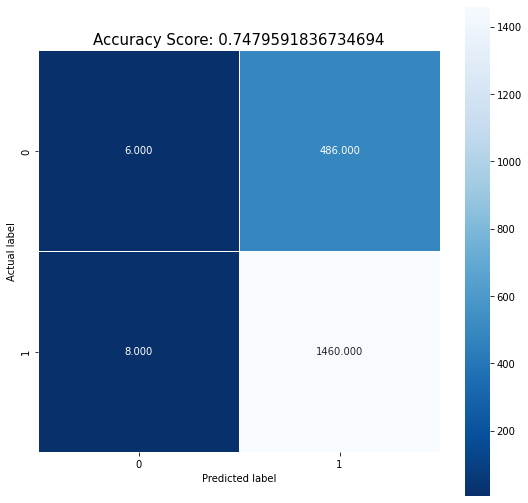

In [11]:
import seaborn as sns

acc_svm = accuracy_score(y_test, grid_predictions)
cm = confusion_matrix(y_test, grid_predictions)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc_svm)
plt.title(all_sample_title, size = 15);

# Treinamento KNN

In [12]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()
model.fit(data_train, np.array(y_train))

KNeighborsClassifier()

In [13]:
predictions_knn = model.predict(data_test)

### Pecision, Recall, F1-Score

In [14]:
print(classification_report(y_test,predictions_knn))

              precision    recall  f1-score   support

           1       0.24      0.07      0.11       492
           4       0.75      0.93      0.83      1468

    accuracy                           0.71      1960
   macro avg       0.50      0.50      0.47      1960
weighted avg       0.62      0.71      0.65      1960



### Matriz de confusão
---------
 0 - gato;
 1 - cachorro

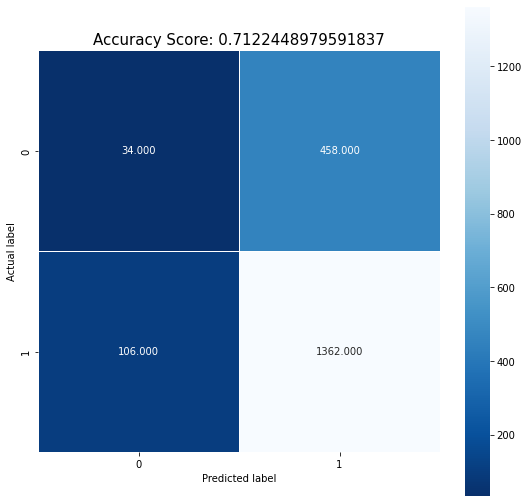

In [15]:
import seaborn as sns

acc_svm = accuracy_score(y_test, predictions_knn)
cm = confusion_matrix(y_test, predictions_knn)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc_svm)
plt.title(all_sample_title, size = 15);

# Treinamento Logistic Regression

In [16]:
from sklearn.linear_model import LogisticRegression

logisticRegr = LogisticRegression()
logisticRegr.fit(data_train, np.array(y_train))

LogisticRegression()

In [17]:
predictions_lr = model.predict(data_test)

### Pecision, Recall, F1-Score

In [18]:
print(classification_report(y_test,predictions_lr))

              precision    recall  f1-score   support

           1       0.24      0.07      0.11       492
           4       0.75      0.93      0.83      1468

    accuracy                           0.71      1960
   macro avg       0.50      0.50      0.47      1960
weighted avg       0.62      0.71      0.65      1960



### Matriz de confusão
---------
 0 - gato;
 1 - cachorro

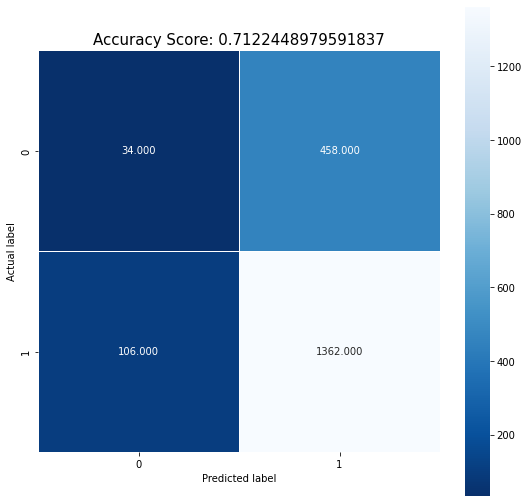

In [19]:
import seaborn as sns

acc_svm = accuracy_score(y_test, predictions_lr)
cm = confusion_matrix(y_test, predictions_lr)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc_svm)
plt.title(all_sample_title, size = 15);